In [6]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time

# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
cmap = cm.RdBu_r



# exptool imports
from exptool.io import psp_io
from exptool.utils import kde_3d
from exptool.observables import transform
from exptool.analysis import pattern
from exptool.analysis import trapping
from exptool.utils import *
from exptool.observables import visualize

# astropy imports
import astropy.coordinates as coord
import astropy.units as u

import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2


import reflexmotion as rm

from scipy.interpolate import UnivariateSpline
from scipy.interpolate import interp1d


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


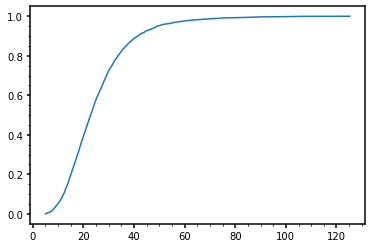

In [7]:
I = np.genfromtxt('../Shells/kgiantrange.txt')
radk = I[:,0]; numk = I[:,1]

plt.plot(radk,numk)

In [2]:
# see https://gea.esac.esa.int/archive/documentation/GDR2/Data_processing/chap_cu3ast/sec_cu3ast_intro/ssec_cu3ast_intro_tansforms.html


def return_gaia_Agprime():
    """return the matrix in eq 3.61, key to transform from ICRS to galactic coordinates"""
    return np.array([[-0.0548755604162154,-0.8734370902348850,-0.4838350155487132],
                     [+0.4941094278755837,-0.4448296299600112,+0.7469822444972189],
                     [-0.8676661490190047,-0.1980763734312015,+0.4559837761750669]])

def return_ricrs(a,d):
    """ eq. 3.57"""
    return np.array([np.cos(a)*np.cos(d),np.sin(a)*np.cos(d),np.sin(d)]).T

def return_picrs(a,d):
    """ eq. 3.64, unit vector of increasing alpha"""
    return np.array([-np.sin(a),np.cos(a),0.]).T

def return_qicrs(a,d):
    """ eq. 3.64, unit vector of increasing delta"""
    return np.array([-np.cos(a)*np.sin(d),-np.sin(a)*np.sin(d),np.cos(d)]).T

def return_muicrs(a,d,mua,mud):
    """ eq. 3.66, the proper motion vector"""
    p = return_picrs(a,d)
    q = return_qicrs(a,d)
    return np.dot(p,mua) + np.dot(q,mud)


def return_rgal(l,b):
    """ eq. 3.58"""
    return np.array([np.cos(l)*np.cos(b),np.sin(l)*np.cos(b),np.sin(b)]).T

def return_pgal(l,b):
    """ eq. 3.66, unit vector of increasing alpha"""
    return np.array([-np.sin(l),np.cos(l),0.]).T

def return_qgal(l,b):
    """ eq. 3.66, unit vector of increasing delta"""
    return np.array([-np.cos(l)*np.sin(b),-np.sin(l)*np.sin(b),np.cos(b)]).T

def return_mugal(l,b,mul,mub):
    """ eq. 3.66, the proper motion vector"""
    p = return_pgal(l,b)
    q = return_qgal(l,b)
    return np.dot(p,mul) + np.dot(q,mub)


def rotate_velocities(a,d,mua,mud):
    """eq 3.68, """
    mu = return_muicrs(a,d,mua,mud)
    mugal = np.dot(return_gaia_Agprime(),mu) # eq. 3.68
    
    # solve for positions
    ricrs = return_ricrs(a,d)
    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell,b = np.arctan2(rgal[1],rgal[0]),np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))
    
    p = return_pgal(ell,b)
    q = return_qgal(ell,b)
    
    mul = np.dot(p.T,mugal)
    mub = np.dot(q.T,mugal)
    #print(mul,mub)
    return mul,mub



def rotate_errors(a,d,pmra_e,pmdec_e,pmcorr):
    ricrs = return_ricrs(a,d)
    picrs = return_picrs(a,d)
    qicrs = return_qicrs(a,d)

    rgal = np.dot(return_gaia_Agprime(),ricrs)

    # implement eq 3.63
    ell = np.arctan2(rgal[1],rgal[0])
    b = np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))

    pgal = return_pgal(ell,b)
    qgal = return_qgal(ell,b)

    pqgal = np.stack((pgal, qgal), axis=-1)
    pqicrs = np.stack((picrs, qicrs), axis=-1)

    cov = np.array([[pmra_e*pmra_e,pmra_e*pmdec_e*pmcorr],[pmra_e*pmdec_e*pmcorr,pmdec_e*pmdec_e]])
    #print(cov)

    G = np.einsum('ab,ac->bc', pqgal,
                      np.einsum('ji,ik->jk', return_gaia_Agprime(), pqicrs))

    cov_to = np.einsum('ba,ac->bc', G,
                           np.einsum('ij,ki->jk', cov, G))
    
    return cov_to

#print(G)

def rotate_positions(a,d,dist):
    """eq 3.68, """
    # solve for positions
    ricrs = return_ricrs(a,d).T
    rgal = np.dot(return_gaia_Agprime(),ricrs)
    return dist*rgal



    
    
a = 45.*np.pi/180.
d = 60.*np.pi/180.

mua = 1.
mud = -1.

#print(return_muicrs(a,d,mua,mud))

print(rotate_velocities(a,d,mua,mud))

cov_to = rotate_errors(a,d,1,2.,0.)
print(cov_to)


#print(ricrs,rgal,ell,b)

(1.3543164832139731, -0.4072184466535577)
[[ 1.67274602 -1.25125971]
 [-1.25125971  3.32725398]]


[ 6.588 67.159 11.838 ...  9.729 17.842 24.018]


(-20.0, 20.0, -2.0, 2.0)

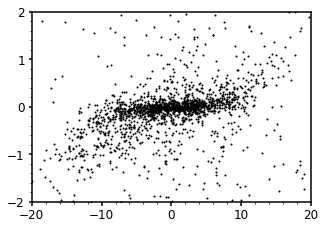

In [3]:
"""
--------------------------------------------------------------------------------
   Bytes Format Units   Label   Explanations
--------------------------------------------------------------------------------
   1- 14 F12.7  deg     RAdeg   Right Ascension in decimal degrees (J2000) 
  16- 27 F12.7  deg     DEdeg   Declination in decimal degrees (J2000)
  29- 40 F12.7  deg     GLON    Galactic longitude                         
  42- 53 F12.7  deg     GLAT    Galactic latitude
  55- 64 F10.6  d       Per     Period
  66- 73 F8.3   kpc     Dis     Distance
  75- 82 F8.3   mag   e_Dis     Error of distance modulus
  84- 91 F8.3   mag   A_Ks      Extinction in Ks band
  93-100 F8.3   mag   e_ext     Extinction bias to distance modulus
 102-104 I1             Type    Optical:0, infrared:1
 106-113 F8.3   mag     Jmag    2MASS J band magnitude                     
 115-122 F8.3   mag     Hmag    2MASS H band magnitude                     
 124-131 F8.3   mag     Ksmag   2MASS K_s_ band magnitude       
 133-140 F8.3   mag     W1mag   Mean WISE W1 (3.35 micron) band magnitude  
 142-149 F8.3   mag     W2mag   Mean WISE W2 (4.6 micron) band magnitude
 151-158 F8.3   mag     [3.6]   Spitzer [3.6] band magnitude
 160-167 F8.3   mag     [4.5]   Spitzer [4.5] band magnitude
 169-176 F8.3   mag     [5.8]   Spitzer [5.8] band magnitude
 178-185 F8.3   mag     [8.0]   Spitzer [8.0] band magnitude
 187-194 F8.4   mas     Plx     Parallax from Gaia DR2
 196-203 F8.4   mas   e_Plx     Error of parallax 
 205-212 F8.3  mas/yr   pmRA    Proper motion in right ascension direction from Gaia DR2
 214-221 F8.3  mas/yr e_pmRA    Error of proper motion in right ascension direction
 223-230 F8.3  mas/yr   pmDE    Proper motion in declination direction from Gaia DR2
 232-239 F8.3  mas/yr e_pmDE    Error of proper motion in declination direction
 241-248 F8.2  km/s     RV      Radial velocity from Gaia DR2
 250-257 F8.2  km/s   e_RV      Error of Radial velocity
 259-266 F8.2  km/s     v_z     Velocity in z direction
 268-275 F8.2  km/s   e_v_z     Error of velocity in z direction                         
--------------------------------------------------------------------------------
"""
CC = np.genfromtxt("data/chen19cepheids.txt",skip_header=33)
#plt.scatter(CC[:,2],CC[:,3])

XCC = rotate_positions(CC[:,0]*np.pi/180.,CC[:,1]*np.pi/180.,CC[:,5])

print(CC[:,5])
plt.scatter(XCC[1],XCC[2],color='black',s=1.)
plt.axis([-20,20,-2,2])

(-360.0, 0.0, -90.0, 90.0)

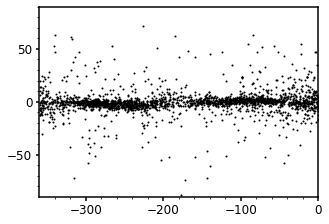

In [4]:
plt.scatter(-CC[:,2],CC[:,3],color='black',s=1.)
plt.axis([-360,0,-90,90])
#print(CC[:,0])


(-20.0, 20.0, -20.0, 20.0)

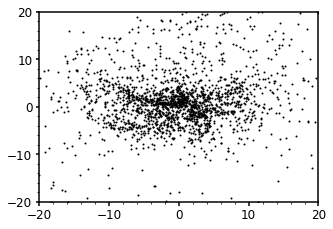

In [5]:
plt.scatter(XCC[1],XCC[0],color='black',s=1.)
plt.axis([-20,20,-20,20])

In [3]:
from exptool.utils import kde_3d

X11 = np.genfromtxt('../Shells/Xue11BHB.txt',\
                        dtype={'names': ("RA","Dec","Glon","Glat",\
                                         "gmag","ug","gr","D0.2","fm",\
                                         "cHg","bHg","d","r",\
                                         "x","y","z","HRV",\
                                         "eHRV","Vgal","DR8","Sloan",\
                                         "SimbadName"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'S20')},\
                 skip_header=77,delimiter=';')



bhbl = X11['Glon']
#bhbl[bhbl > 180.] -= 360.


bhbb = X11['Glat']

xx,yy,bhbw = kde_3d.total_kde_two(bhbl,-bhbb,\
                                       gridsize=256,\
                                       #extents=(-180,180.,-90,90),\
                                       extents=(0.,360.,-90,90),\
                                       #weights=PSPDump.mass/np.cos(halob),\
                                       ktype='gaussian',npower=6.)


# print the SDSS map to a file
#f = open('../Shells/sdssmap.txt','w')

xxf = xx.reshape(-1,)
yyf = yy.reshape(-1,)
sdssf = bhbw.reshape(-1,)


def interpolate_map(l,b,xx,yy,bhbw,dens=5.0,verbose=False):

    f = interpolate.RectBivariateSpline(xx[0],yy[:,0],np.abs(np.log10((bhbw.T)+1.e-12)))
    f = interpolate.RectBivariateSpline(xx[0]*np.pi/180.,yy[:,0]*np.pi/180.,np.abs(np.log10((bhbw.T)+1.e-12)))


    #f = interpolate.RectBivariateSpline(xx[0],yy[:,0],np.abs(np.log10(bhbw.T+1.e-12)))



    bhbdens = f.ev(l,b)

    if verbose: plt.plot(bhbdens[bhbdens.argsort()])

    sdss = np.where(bhbdens<dens)
    sdssflag = np.zeros(l.size)
    sdssflag[bhbdens<dens] += 1

    return sdssflag


#plt.contour(xx,yy,np.abs(np.log10((bhbw)+1.e-12)),[5.0])

In [14]:
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s14n.00097','dark')
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s13n.00098','dark')
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s15n.00095','dark')

indir = '/Volumes/SIMSET/Disk065/'


inputfile = indir+'OUT.run065s13n.00000'
inputfile = '/Volumes/SIMSET/Disk065/OUT.run065s15n.00095'
inputfile = '/Volumes/SIMSET/Disk065/OUT.run065s14n.00097'
#inputfile = '/Volumes/External1/Disk068/Run22Disk/OUT.run068s22idm3.00106'

#inputfile = '/Volumes/External1/Disk068/Run22Disk/OUT.run068s22idm3.00114'





In [15]:

from exptool.io import particle
#indir = '/Users/mpetersen/Downloads/'

try:
    MWH = particle.Input(inputfile,'dark',legacy=True)
except:
    MWH = particle.Input(inputfile,'mw',legacy=True)





nout = 300000

xpos = 300.*MWH.xpos[0:nout]
ypos = 300.*MWH.ypos[0:nout]
zpos = -300.*MWH.zpos[0:nout]
xvel = 160.*MWH.xvel[0:nout]
yvel = 160.*MWH.yvel[0:nout]
zvel = -160.*MWH.zvel[0:nout]

print(np.nanmedian(300.*MWH.zpos),np.nanmedian(160.*MWH.zvel))

xpos -= np.nanmedian(300.*MWH.xpos)
ypos -= np.nanmedian(300.*MWH.ypos)
zpos -= np.nanmedian(-300.*MWH.zpos)
xvel -= np.nanmedian(160.*MWH.xvel)
yvel -= np.nanmedian(160.*MWH.yvel)
zvel -= np.nanmedian(-160.*MWH.zvel)




19.764675 38.31082


In [16]:
try:
    MWD = particle.Input(inputfile,'star',legacy=True)
except:
    MWD = particle.Input(inputfile,'disc',legacy=True)




# how thick is the disc?
sclfac = 1.

noutd = 300000

dfac = 300.
vfac = 160.

flipz = 1.

xposd = 300.*MWD.xpos[0:noutd]
yposd = 300.*MWD.ypos[0:noutd]
zposd = flipz*300.*MWD.zpos[0:noutd]*sclfac
xveld = 160.*MWD.xvel[0:noutd]
yveld = 160.*MWD.yvel[0:noutd]
zveld = flipz*160.*MWD.zvel[0:noutd]

print(np.nanmedian(300.*MWD.zpos),np.nanmedian(160.*MWD.zvel))

xposd -= np.nanmedian(300.*MWD.xpos)
yposd -= np.nanmedian(300.*MWD.ypos)
zposd -= np.nanmedian(flipz*300.*MWD.zpos)
xveld -= np.nanmedian(160.*MWD.xvel)
yveld -= np.nanmedian(160.*MWD.yvel)
zveld -= np.nanmedian(flipz*160.*MWD.zvel)

20.533613 88.45229


In [17]:

Lx = yposd*zveld - zposd*yveld
Ly = zposd*xveld - xposd*zveld
Lz = xposd*yveld - yposd*xveld

rposd = np.sqrt(xposd*xposd + yposd*yposd)

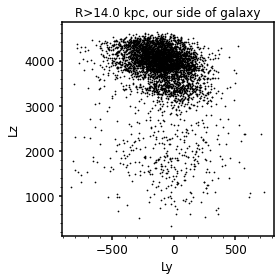

In [20]:
rlim = 14.0
xlim = 0.
rlim2 = 17.0
criteria = (rposd>rlim) & (xposd<xlim) & (rposd<rlim2)

plt.figure(figsize=(4,4))

plt.scatter(Ly[criteria],Lz[criteria],color='black',s=.5)

plt.xlabel('Ly')
plt.ylabel('Lz')
plt.title('R>{} kpc, our side of galaxy'.format(rlim))
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/angmomLMC.png',dpi=300)

#plt.scatter(Ly[rposd<rlim],Lz[rposd<rlim],color='grey',s=.5)

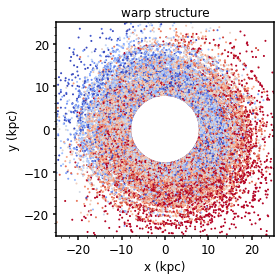

In [117]:
plt.figure(figsize=(4,4))


plt.scatter(xposd[rposd>rlim],yposd[rposd>rlim],color=cm.coolwarm((zposd[rposd>rlim]+1.)/2.),s=1.)

#plt.scatter(xposd[rposd>rlim],yposd[rposd>rlim],color=cm.coolwarm((yveld[rposd>rlim]+200.)/400.),s=1.)
#plt.scatter(xposd[rposd>rlim],yposd[rposd>rlim],color=cm.coolwarm((zveld[rposd>rlim]+20.)/40.),s=.5)



plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('warp structure'.format(rlim))
plt.axis([-25,25,-25,25])
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/warpstructure.png',dpi=300)

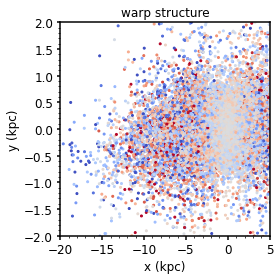

In [30]:
plt.figure(figsize=(4,4))


criteria = (rposd>rlim) & (rposd<rlim2)
criteria = np.abs(yposd)<.5

plt.scatter(xposd[criteria],zposd[criteria],color=cm.coolwarm((Ly[criteria]+400)/800.),s=4.)

#plt.scatter(xposd[rposd>rlim],yposd[rposd>rlim],color=cm.coolwarm((yveld[rposd>rlim]+200.)/400.),s=1.)
#plt.scatter(xposd[rposd>rlim],yposd[rposd>rlim],color=cm.coolwarm((zveld[rposd>rlim]+20.)/40.),s=.5)


plt.xlabel('x (kpc)')
plt.ylabel('y (kpc)')
plt.title('warp structure'.format(rlim))
plt.axis([-20,5,-2,2])
plt.tight_layout()
plt.savefig('/Users/mpetersen/Downloads/warpstructure.png',dpi=300)

In [118]:
LMC = psp_io.Input(inputfile,'lmc')

print(300.*np.nanmedian(LMC.data['x']-np.nanmedian(MWD.xpos)))
print(300.*np.nanmedian(LMC.data['y']-np.nanmedian(MWD.ypos)))
print(300.*np.nanmedian(LMC.data['z']-np.nanmedian(MWD.zpos)))




OSError: Failed to open "/Volumes/SIMSET/Disk065/OUT.run065s14n.00097"

In [ ]:
plt.scatter(yposd[rposd>rlim],zposd[rposd>rlim],color=cm.coolwarm((zposd[rposd>rlim]+1.)/2.),s=.5)

In [6]:
MWH.mass.size,MWD.mass.size
MWH.mass.size,MWD.mass.size

(10000000, 1000000)

In [7]:
# add disc

xpos = np.concatenate([xpos,xposd])
ypos = np.concatenate([ypos,yposd])
zpos = np.concatenate([zpos,zposd])
xvel = np.concatenate([xvel,xveld])
yvel = np.concatenate([yvel,yveld])
zvel = np.concatenate([zvel,zveld])


In [8]:
disc = np.concatenate([np.zeros(nout),np.ones(noutd)])
print(disc.size)

600000


-1.5692914 1.5664839


(-400.0, 400.0, -400.0, 400.0)

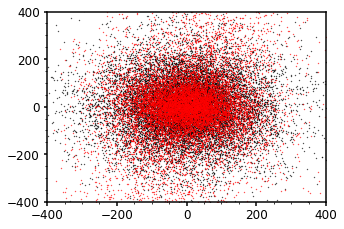

In [9]:


Lx = ypos*zvel - zpos*yvel
Ly = zpos*xvel - xpos*zvel
Lz = xpos*yvel - ypos*xvel

rad3 = np.sqrt(xpos*xpos+ypos*ypos+zpos*zpos)
rad2 = np.sqrt(xpos*xpos+ypos*ypos)
vr = (xpos*xvel + ypos*yvel + zpos*zvel)/rad3
vphi = -Lz/rad2


ltest = np.arctan2(ypos,xpos-8.16) + np.pi
btest = np.arccos(zpos/np.sqrt(xpos*xpos+ypos*ypos+zpos*zpos)) - np.pi/2.
print(np.nanmin(btest),np.nanmax(btest))
sdssflagall = interpolate_map(ltest,btest,xx,yy,bhbw,dens=5.0,verbose=False)


criteria = (disc==0) & (sdssflagall==1)
#plt.scatter(Lx[criteria][::10],Lz[criteria][::10],color='black',s=.1,alpha=1.)

Lx = (ypos+50.)*zvel - zpos*yvel
Ly = zpos*xvel - xpos*zvel
Lz = (xpos-4.)*yvel - (ypos+50.)*xvel
#plt.scatter(Lx[criteria][::10],Lz[criteria][::10],color='red',s=.1,alpha=.1)



#plt.scatter(ltest[criteria][::10],btest[criteria][::10],color='black',s=.1)

plt.scatter(vr[criteria][::10],vphi[criteria][::10],color='black',s=.1,alpha=1.)

rad3 = np.sqrt((xpos+20.)*(xpos+20.)+ypos*ypos+zpos*zpos)
vr = ((xpos+20.)*xvel + ypos*yvel + zpos*zvel)/rad3
rad3 = np.sqrt((xpos+20.)*(xpos+20.)+ypos*ypos)

vphi = -Lz/rad2


plt.scatter(vr[criteria][::10],vphi[criteria][::10],color='red',s=.1,alpha=1.)
plt.axis([-400,400,-400,400])



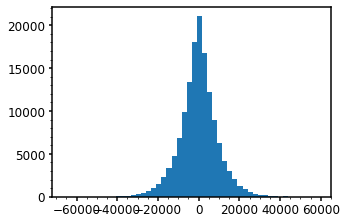

In [10]:
_ = plt.hist(Lz[criteria],bins=50)

(-100.0, 100.0, -100.0, 100.0)

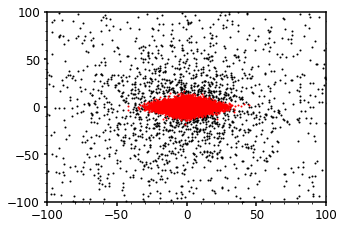

In [11]:
plt.scatter(xpos[::100],zpos[::100],color='black',s=1.)
plt.scatter(xpos[disc==1],zpos[disc==1],color='red',s=1.)


plt.axis([-100,100,-100,100])

In [12]:
rvals = np.sqrt(xpos*xpos + ypos*ypos + zpos*zpos)



In [13]:
w = np.where((rvals>50) & (rvals<100))[0]

print(np.nanmedian(xvel[w]),np.nanmedian(yvel[w]),np.nanmedian(zvel[w]))



0.78068715 -0.28594717 -0.04761896


In [14]:
# put in Cartesian observables
rsun = [-8.21,0.,0.02]
vsun = [11.1, 244.24, 7.25]

#xpos += rsun[0]
#ypos += rsun[1]
#zpos += rsun[2]
#xvel += vsun[0]
#yvel += vsun[1]
#zvel += vsun[2]


In [15]:
import reflexmotion.galactic as gt
import reflexmotion.outlog as ol

In [16]:
dLj,dBj,radj,vrj,dmulj,dmubj = gt.galactic(xpos-rsun[0],\
#dLj,dBj,radj,vrj,dmulj,dmubj = jorge_galactic(xpos+rsun[0],\
                                           ypos-rsun[1],\
                                           zpos-rsun[2],\
                                           xvel-vsun[0],\
                                           yvel-vsun[1],\
                                           zvel-vsun[2],twopi=True)




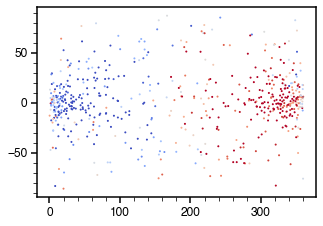

In [73]:
plt.scatter(dLj[::1000],dBj[::1000],color=cm.coolwarm((vrj[::1000]+200.)/400.,1.),s=1.)

In [74]:
xpos.size

600000

In [75]:

from scipy.interpolate import interp1d

def draw_sources(radk,numk,radj,nsources = 15000):
    """ draw sources from an input distribution to match a specified distribution
    
    inputs
    ---------
    radk     : 
    numk     :
    radj     :
    nsources :
    
    """
    # interpolate the input distribution
    
    spl = interp1d(numk,radk,'nearest')
    
    used = np.zeros(nsources,dtype='int')
    desdist = np.zeros(nsources)

    for i in range(0,nsources):
        #if i%1500==0:print(i)
        r = np.random.rand()
        desired_dist = spl(r)
        desdist[i] = desired_dist

        # set up a distance tolerance of 1%.
        # should this be converted to a heliocentric distance?
        w = np.where( (radj > 0.99*desired_dist) & (radj < 1.01*desired_dist))[0]

        # randomly select a star from the list
        t = np.random.choice(w)

        draws = 0
        while t in used:
            t = np.random.choice(w)
            draws+=1
            #if draws==w.size:
                #print('failure',w.size)
                #t = 1000000+i

        used[i] = t

    return used,desdist,spl



I = np.genfromtxt('../Shells/kgiantrange.txt')
radk = I[:,0]; numk = I[:,1]

#used,desdist,spl = draw_sources(radk,numk,radj[0:1000000],nsources = 15000)
used,desdist,spl = draw_sources(radk,numk,radj,nsources = 15000)



In [76]:
radj.size

600000

[]

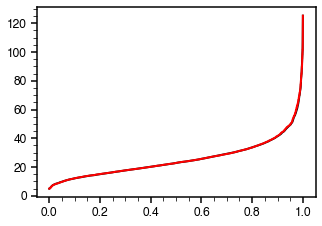

In [77]:
tstdist = np.linspace(0.,1.,1000)
plt.plot(tstdist,spl(tstdist),color='black')

tstdist = np.linspace(0.,1.,desdist.size)
plt.plot(tstdist,desdist[desdist.argsort()],color='red')

plt.plot()

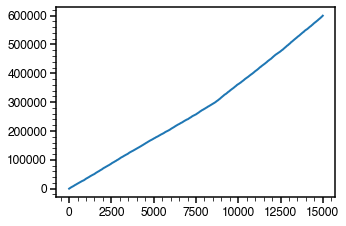

In [78]:
plt.plot(used[used.argsort()])

In [79]:
used.size

15000

In [80]:
print(np.nansum(disc[used]))

6346.0


In [81]:

def jorge_galactic(x0,y0,z0,u0,v0,w0,twopi=True):
    
    rad = np.sqrt(x0**2+y0**2+z0**2)
    xphi= np.arctan2(y0,x0)
    xth = np.arccos(z0/rad)
    
    xur = np.zeros([3,x0.size])
    xur[0]= np.sin(xth)*np.cos(xphi)
    xur[1]= np.sin(xth)*np.sin(xphi)
    xur[2]= np.cos(xth)
         
    xuth = np.zeros([3,x0.size])
    xuth[0]= np.cos(xth)*np.cos(xphi)
    xuth[1]= np.cos(xth)*np.sin(xphi)
    xuth[2]=-np.sin(xth)

    xuphi = np.zeros([3,x0.size])
    xuphi[0]=-np.sin(xphi)
    xuphi[1]=+np.cos(xphi)
    xuphi[2]= 0.
    
    vr =    u0*  xur[0] + v0*  xur[1] + w0*  xur[2]
    vth=    u0* xuth[0] + v0* xuth[1] + w0* xuth[2]
    vphi=   u0*xuphi[0] + v0*xuphi[1] + w0*xuphi[2]
          
    vb= -vth
    
    # match the astropy output
    vl= vphi
         
    dk  =4.74057           #conversion from km/s
    par =1./rad             #arc sec --> rad in [kpc]
    dmul=vl / dk * par
    dmub=vb / dk * par

    f=np.pi/180.
    dB=np.arcsin(z0/rad)/f
    
    if twopi:
        dL=np.arctan(y0/x0)/f
        dL[(y0<0)&(x0>0.)] += 360.
        dL[(y0>0)&(x0<0.)] += 180.
        dL[(y0<0)&(x0<0.)] += 180.
    else:
        dL = np.arctan2(y0,x0)/f

    
    return dL,dB,rad,vr,dmul,dmub





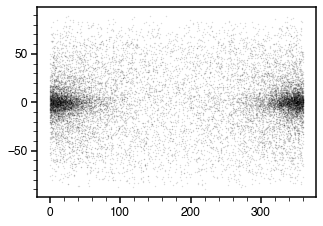

In [82]:
plt.scatter(dLj[used],dBj[used],color='black',s=0.1,alpha=0.2)

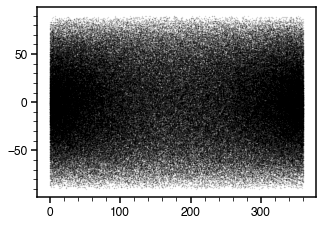

In [83]:
plt.scatter(dLj[disc==0],dBj[disc==0],color='black',s=0.1,alpha=0.2)

In [84]:
sdssflag = interpolate_map(dLj*(np.pi/180.),dBj*(np.pi/180.),xx,yy,bhbw,dens=5.0,verbose=False)

sdssflag.size,dLj.size

(600000, 600000)

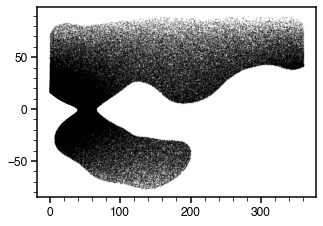

In [85]:
sdssflag = interpolate_map(dLj*(np.pi/180.),dBj*(np.pi/180.),xx,yy,bhbw,dens=5.0,verbose=False)

sdssflag.size,dLj.size
plt.scatter(dLj[sdssflag==1],dBj[sdssflag==1],color='black',s=0.1,alpha=0.2)

In [86]:
print(np.nansum((sdssflag[used]==1)&(disc[used]==1)))

1066


In [87]:


#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/erkal_2020_mock.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s14_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s13_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s15_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_35k_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric_noisy.txt'

outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_disc_0_15k_all_heliocentric_noisy.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_disc_1_15k_all_heliocentric_noisy.txt'





f = open(outfile,'w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     dL [deg]; dB [deg]; dist [kpc]; vlos [km/s]; dmul [marcsec/yr]; dmub [marcsec/yr]; \
      edist[kpc]; evlos [km/s]; edmul [marcsec/yr]; edmub [marcsec/yr]; \
      rapo [kpc]; disc; sdss?; [dead]; [dead]; [dead]; corr ',file=f)

# x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; 
# l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];      
# edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];  
# [dead] ; [dead] ; [dead] ; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]

# distance-dependent error factors
pmprefac=  0.013
pmprefac=  0.008 # test a down-weighting of uncertainties

pmprefac=  0.004 # edr3?

dprefac = 0.2
# set up blank rapo and rapoquality
rapo = np.ones(xpos.size)
rapoquality = np.zeros(xpos.size)


for i in used:

    print(np.round(xpos[i],2),\
          np.round(ypos[i],2),\
          np.round(zpos[i],2),\
          np.round(xvel[i],2),\
          np.round(yvel[i],2),\
          np.round(zvel[i],2),\
        np.round(dLj[i],2),\
          np.round(dBj[i],2),\
          np.round(radj[i]+np.random.normal(0,0.05*radj[i]),2),\
          np.round( vrj[i]+np.random.normal(0,dprefac*radj[i]),2),\
          np.round( dmulj[i]+np.random.normal(0,pmprefac*radj[i]),4),\
          np.round( dmubj[i]+np.random.normal(0,pmprefac*radj[i]),4),\
        np.round(0.05*radj[i],2),\
          np.round(np.abs(dprefac*radj[i]*np.random.normal()),2),\
          np.round(np.abs(pmprefac*radj[i]*np.random.normal()),4),\
          np.round(np.abs(pmprefac*radj[i]*np.random.normal()),4),\
        500.,\
          int(disc[i]),\
        int(sdssflag[i]),\
          0.0,0.0,0,0.0,\
          file=f)
    
f.close()









In [88]:


#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/erkal_2020_mock.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s14_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s13_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/model_s15_erd3_estimates.txt'

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_35k_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric.txt'
#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric_noisefree.txt'

outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_disc_0_15k_all_heliocentric_noisefree.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_disc_1_15k_all_heliocentric_noisefree.txt'





f = open(outfile,'w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     dL [deg]; dB [deg]; dist [kpc]; vlos [km/s]; dmul [marcsec/yr]; dmub [marcsec/yr]; \
      edist[kpc]; evlos [km/s]; edmul [marcsec/yr]; edmub [marcsec/yr]; \
      rapo [kpc]; disc; sdss?; [dead]; [dead]; [dead]; corr ',file=f)

# x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; 
# l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];      
# edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];  
# [dead] ; [dead] ; [dead] ; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]

# distance-dependent error factors
pmprefac=  0.013
pmprefac=  0.008 # test a down-weighting of uncertainties

pmprefac=  0.004 # edr3?

dprefac = 0.2
# set up blank rapo and rapoquality
rapo = np.ones(xpos.size)
rapoquality = np.zeros(xpos.size)


for i in used:

    print(np.round(xpos[i],2),\
          np.round(ypos[i],2),\
          np.round(zpos[i],2),\
          np.round(xvel[i],2),\
          np.round(yvel[i],2),\
          np.round(zvel[i],2),\
        np.round(dLj[i],2),\
          np.round(dBj[i],2),\
          np.round(radj[i],2),\
          np.round( vrj[i],2),\
          np.round( dmulj[i],4),\
          np.round( dmubj[i],4),\
        np.round(0.*0.05*radj[i],2),\
          np.round(0.*np.abs(dprefac*radj[i]*np.random.normal()),2),\
          np.round(0.*np.abs(pmprefac*radj[i]*np.random.normal()),4),\
          np.round(0.*np.abs(pmprefac*radj[i]*np.random.normal()),4),\
        500.,\
          int(disc[i]),\
        int(sdssflag[i]),\
          0.0,0.0,0,0.0,\
          file=f)
    
f.close()










3715
15000


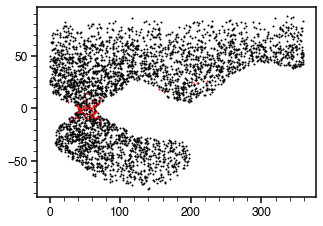

In [97]:

#outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_gse_0_15k_all_heliocentric_noisy.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_disc_0_15k_all_heliocentric_noisy.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_disc_1_15k_all_heliocentric_noisy.txt'




In = np.genfromtxt(outfile,skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

ra   = In[:,16]
gse  = In[:,17]
sd   = In[:,18]

r = np.sqrt(x*x+y*y+z*z)
print(len(np.where((sd==1) & (d>20))[0]))

dlim = r>20
plt.scatter(l[(sd==1) &(gse==0) & (dlim)],b[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
plt.scatter(l[(sd==1) &(gse==1) & (dlim)],b[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)
print(sd.size)

#plt.scatter(d[(sd==1) &(gse==0) & (dlim)],dmb[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
#plt.scatter(d[(sd==1) &(gse==1) & (dlim)],dmb[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)



#plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)

In [52]:

print(np.nansum(gse[(sd==1) & (d>20)]))
print(np.nansum(gse[(sd>=0) & (r>20)])/len(gse[(sd>=0) & (r>20)]))
print(len(gse[(sd==1) & (r>20)]))




42.0
0.021421370967741934
3866


## SGR

0.01050638 0.034376133
(100000, 34)


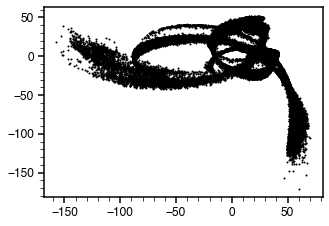

In [122]:
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s14n.00097','dark')
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s13n.00098','dark')
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s15n.00095','dark')

from exptool.io import particle
#MWH = psp_io.Input('/Volumes/SIMSET/Disk065/OUT.run065s13n.00000','dark',nout=300000)

indir = '/Volumes/SIMSET/Disk065/'
indir = '/Users/mpetersen/Downloads'
MWH = particle.Input(indir+'OUT.run065s13n.00000','dark',legacy=True)



nout = 200000

xpos = 300.*MWH.xpos[0:nout]
ypos = 300.*MWH.ypos[0:nout]
zpos = -300.*MWH.zpos[0:nout]
xvel = 160.*MWH.xvel[0:nout]
yvel = 160.*MWH.yvel[0:nout]
zvel = -160.*MWH.zvel[0:nout]

print(np.nanmedian(300.*MWH.zpos),np.nanmedian(160.*MWH.zvel))

xpos -= np.nanmedian(300.*MWH.xpos)
ypos -= np.nanmedian(300.*MWH.ypos)
zpos -= np.nanmedian(-300.*MWH.zpos)
xvel -= np.nanmedian(160.*MWH.xvel)
yvel -= np.nanmedian(160.*MWH.yvel)
zvel -= np.nanmedian(-160.*MWH.zvel)

SGR = np.genfromtxt('/Users/mpetersen/Dropbox/mike/Sgr_model/Sgr_model.dat')
print(SGR.shape)
#print(SGR[:,])
#plt.scatter(SGR[:,19]+SGR[:,2],SGR[:,20]+SGR[:,3],color='black',s=1.)
#plt.scatter(SGR[:,19]+SGR[:,2],SGR[:,21]+SGR[:,4],color='black',s=1.)

nouts = 100000


xposs = (SGR[:,2]+SGR[:,19])[0:nouts]
yposs = (SGR[:,3]+SGR[:,20])[0:nouts]
zposs = (SGR[:,4]+SGR[:,21])[0:nouts]
xvels = (SGR[:,5]+SGR[:,22])[0:nouts]
yvels = (SGR[:,6]+SGR[:,23])[0:nouts]
zvels = (SGR[:,7]+SGR[:,24])[0:nouts]

plt.scatter(xposs,zposs,color='black',s=1.)




In [123]:
# add sgr

xpos = np.concatenate([xpos,xposs])
ypos = np.concatenate([ypos,yposs])
zpos = np.concatenate([zpos,zposs])
xvel = np.concatenate([xvel,xvels])
yvel = np.concatenate([yvel,yvels])
zvel = np.concatenate([zvel,zvels])




300000
-1.5699254937782583 1.5664772864828183


(-400.0, 400.0, -400.0, 400.0)

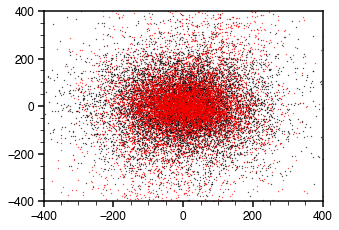

In [124]:
sgr = np.concatenate([np.zeros(nout),np.ones(nouts)])
print(sgr.size)

Lx = ypos*zvel - zpos*yvel
Ly = zpos*xvel - xpos*zvel
Lz = xpos*yvel - ypos*xvel

rad3 = np.sqrt(xpos*xpos+ypos*ypos+zpos*zpos)
rad2 = np.sqrt(xpos*xpos+ypos*ypos)
vr = (xpos*xvel + ypos*yvel + zpos*zvel)/rad3
vphi = -Lz/rad2


ltest = np.arctan2(ypos,xpos-8.16) + np.pi
btest = np.arccos(zpos/np.sqrt(xpos*xpos+ypos*ypos+zpos*zpos)) - np.pi/2.
print(np.nanmin(btest),np.nanmax(btest))
sdssflagall = interpolate_map(ltest,btest,xx,yy,bhbw,dens=5.0,verbose=False)


criteria = (sgr==0) & (sdssflagall==1)
#plt.scatter(Lx[criteria][::10],Lz[criteria][::10],color='black',s=.1,alpha=1.)

Lx = (ypos+50.)*zvel - zpos*yvel
Ly = zpos*xvel - xpos*zvel
Lz = (xpos-4.)*yvel - (ypos+50.)*xvel
#plt.scatter(Lx[criteria][::10],Lz[criteria][::10],color='red',s=.1,alpha=.1)



#plt.scatter(ltest[criteria][::10],btest[criteria][::10],color='black',s=.1)

plt.scatter(vr[criteria][::10],vphi[criteria][::10],color='black',s=.1,alpha=1.)

rad3 = np.sqrt((xpos+20.)*(xpos+20.)+ypos*ypos+zpos*zpos)
vr = ((xpos+20.)*xvel + ypos*yvel + zpos*zvel)/rad3
rad3 = np.sqrt((xpos+20.)*(xpos+20.)+ypos*ypos)

vphi = -Lz/rad2


plt.scatter(vr[criteria][::10],vphi[criteria][::10],color='red',s=.1,alpha=1.)
plt.axis([-400,400,-400,400])




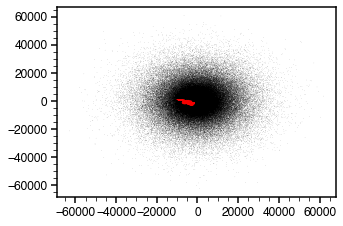

In [127]:

Lx = ypos*zvel - zpos*yvel
Ly = zpos*xvel - xpos*zvel
Lz = xpos*yvel - ypos*xvel

plt.scatter(Ly,Lz,edgecolor='none',facecolor='black',s=.1)
plt.scatter(Ly[sgr==1],Lz[sgr==1],edgecolor='none',facecolor='red',s=.1)

In [128]:
dLj,dBj,radj,vrj,dmulj,dmubj = gt.galactic(xpos-rsun[0],\
                                           ypos-rsun[1],\
                                           zpos-rsun[2],\
                                           xvel-vsun[0],\
                                           yvel-vsun[1],\
                                           zvel-vsun[2],twopi=True)





In [129]:

I = np.genfromtxt('../Shells/kgiantrange.txt')
radk = I[:,0]; numk = I[:,1]

#used,desdist,spl = draw_sources(radk,numk,radj[0:1000000],nsources = 15000)
used,desdist,spl = draw_sources(radk,numk,radj,nsources = 15000)




[]

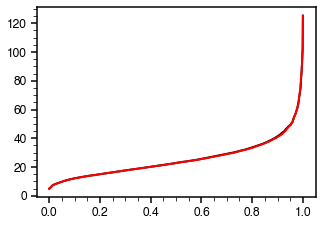

In [130]:
tstdist = np.linspace(0.,1.,1000)
plt.plot(tstdist,spl(tstdist),color='black')

tstdist = np.linspace(0.,1.,desdist.size)
plt.plot(tstdist,desdist[desdist.argsort()],color='red')

plt.plot()

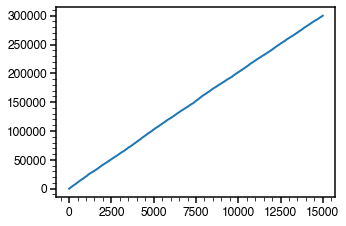

In [131]:
plt.plot(used[used.argsort()])


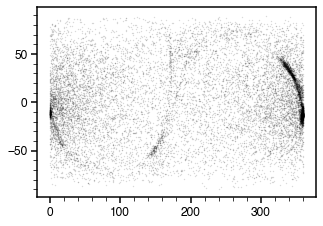

In [132]:
plt.scatter(dLj[used],dBj[used],color='black',s=0.1,alpha=0.2)

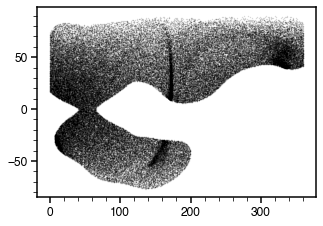

In [133]:
sdssflag = interpolate_map(dLj*(np.pi/180.),dBj*(np.pi/180.),xx,yy,bhbw,dens=5.0,verbose=False)

sdssflag.size,dLj.size
plt.scatter(dLj[sdssflag==1],dBj[sdssflag==1],color='black',s=0.1,alpha=0.2)

In [134]:

outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_sgr_0_15k_all_heliocentric_noisy.txt'





f = open(outfile,'w')


print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; \
     dL [deg]; dB [deg]; dist [kpc]; vlos [km/s]; dmul [marcsec/yr]; dmub [marcsec/yr]; \
      edist[kpc]; evlos [km/s]; edmul [marcsec/yr]; edmub [marcsec/yr]; \
      rapo [kpc]; sgr; sdss?; [dead]; [dead]; [dead]; corr ',file=f)

# x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s]; 
# l [deg]; b [deg]; dist [kpc]; vlos [km/s]; dmu_l [marcsec/yr]; dmu_b [marcsec/yr];      
# edist[kpc]; evlost [km/s]; edmu_l [marcsec/yr]; edmu_b [marcsec/yr];  
# [dead] ; [dead] ; [dead] ; Sgr Lambda [deg]; Sgr Beta [deg]; Belokurov Flag [bool]; corrcoef [-1:1]

# distance-dependent error factors
pmprefac=  0.013
pmprefac=  0.008 # test a down-weighting of uncertainties

pmprefac=  0.004 # edr3?

dprefac = 0.2
# set up blank rapo and rapoquality
rapo = np.ones(xpos.size)
rapoquality = np.zeros(xpos.size)


for i in used:

    print(np.round(xpos[i],2),\
          np.round(ypos[i],2),\
          np.round(zpos[i],2),\
          np.round(xvel[i],2),\
          np.round(yvel[i],2),\
          np.round(zvel[i],2),\
        np.round(dLj[i],2),\
          np.round(dBj[i],2),\
          np.round(radj[i]+np.random.normal(0,0.05*radj[i]),2),\
          np.round( vrj[i]+np.random.normal(0,dprefac*radj[i]),2),\
          np.round( dmulj[i]+np.random.normal(0,pmprefac*radj[i]),4),\
          np.round( dmubj[i]+np.random.normal(0,pmprefac*radj[i]),4),\
        np.round(0.05*radj[i],2),\
          np.round(np.abs(dprefac*radj[i]*np.random.normal()),2),\
          np.round(np.abs(pmprefac*radj[i]*np.random.normal()),4),\
          np.round(np.abs(pmprefac*radj[i]*np.random.normal()),4),\
        500.,\
          int(sgr[i]),\
        int(sdssflag[i]),\
          0.0,0.0,0,0.0,\
          file=f)
    
f.close()










3194
15000


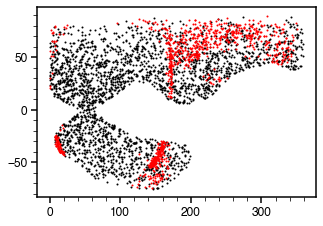

In [135]:


In = np.genfromtxt(outfile,skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

ra   = In[:,16]
gse  = In[:,17]
sd   = In[:,18]

r = np.sqrt(x*x+y*y+z*z)
print(len(np.where((sd==1) & (d>20))[0]))

dlim = r>20
plt.scatter(l[(sd==1) &(gse==0) & (dlim)],b[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
plt.scatter(l[(sd==1) &(gse==1) & (dlim)],b[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)
print(sd.size)

#plt.scatter(d[(sd==1) &(gse==0) & (dlim)],dmb[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
#plt.scatter(d[(sd==1) &(gse==1) & (dlim)],dmb[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)



#plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)

10939
50000


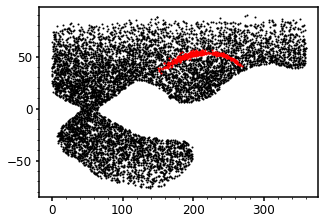

In [18]:

outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_oc_sgr_0_50k_all_heliocentric_noisefree.txt'



In = np.genfromtxt(outfile,skip_header=1)


x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

ra   = In[:,16]
gse  = In[:,17]
sd   = In[:,18]

r = np.sqrt(x*x+y*y+z*z)
print(len(np.where((sd==1) & (d>20))[0]))

dlim = r>20
plt.scatter(l[(sd==1) &(gse==0) & (dlim)],b[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
plt.scatter(l[(sd==1) &(gse==1) & (dlim)],b[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)
print(sd.size)

#plt.scatter(d[(sd==1) &(gse==0) & (dlim)],dmb[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
#plt.scatter(d[(sd==1) &(gse==1) & (dlim)],dmb[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)



#plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)

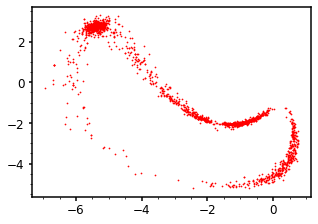

In [43]:
import reflexmotion.definecoordinates as dc

aval,dval = dc.rotate_observed(l[gse==1]*np.pi/180.,b[gse==1]*np.pi/180.)
muaval,mudval = dc.rotate_velocities_observed(l[gse==1]*np.pi/180.,b[gse==1]*np.pi/180.,dml[gse==1],dmb[gse==1])




plt.scatter(muaval,mudval,color='red',s=0.5)



In [35]:
print(l[gse==1])

[301.31 235.68 300.36 ... 299.6  353.23 299.61]


In [46]:
#print(x[(sd==1) &(gse==1) & (dlim)])

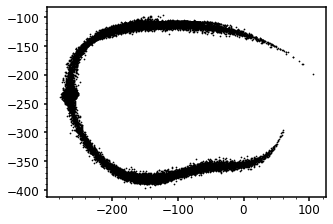

In [128]:
# 1,2,2) Galactocentric x, y, z (kpc)
# 4,5,6) Galactocentric vx, vy, vz (km/s)
# 7,8) ra, dec (deg)
# 9) dhel (kpc)
# 10) vr (km/s)
# 11,12) pmra, pmdec (mas/yr)
# 13) Closest approach to LMC (kpc)

OCin = np.genfromtxt('/Users/mpetersen/Downloads/orphan_stream.txt')
OC = dict()
keys = ['x','y','z','vx','vy','vz','ra','dec','dhel','vr','pmra','pmdec','dlmc']

for k,key in enumerate(keys):
    OC[key] = OCin[:,k]
    if key=='ra':
        OC[key][OC[key]>180.] -= 360.
    if key=='x':
        OC[key] -= 8.1
    '''if key=='vx':
        OC[key] += 11.1
    if key=='vy':
        OC[key] += 245
    if key=='vz':
        OC[key] += 7.3'''

#plt.scatter(OC['ra'],OC['dec'],color='black',s=1.)


ltest,btest = dc.rotate_positions(OC['ra']*np.pi/180.,OC['dec']*np.pi/180.)
multest,mubtest = dc.rotate_velocities(OC['ra']*np.pi/180.,OC['dec']*np.pi/180.,OC['pmra'],OC['pmdec'])

vxtest,vytest,vztest = dc.rotate_velocities_cartesian(OC['ra']*np.pi/180.,OC['dec']*np.pi/180.,OC['dhel'],OC['pmra'],OC['pmdec'],OC['vr'])
xtest,ytest,ztest = dc.rotate_positions_cartesian(OC['ra']*np.pi/180.,OC['dec']*np.pi/180.,OC['dhel'])



#plt.scatter(ltest*180./np.pi,btest*180./np.pi,color='black',s=0.5)

#plt.scatter(multest,mubtest,color='black',s=0.5)
#plt.scatter(vxtest,vytest,color='black',s=0.5)
#plt.scatter(xtest-8.,ytest,color='black',s=0.5)
plt.scatter(OC['vx'],OC['vy'],color='black',s=0.5)






#plt.scatter(aval*180./np.pi,dval*180./np.pi,color='red',s=0.5)

#plt.scatter(muaval,mudval,color='red',s=0.5)



#print(vr[(sd==1) &(gse==1) & (dlim)])
#plt.scatter(l[gse==1],b[gse==1],color='red',s=0.5)
#plt.scatter(dml[gse==1],dmb[gse==1],color='red',s=0.5)

#plt.scatter(vx[gse==1],vz[gse==1],color='red',s=0.5)


#OC['l'],OC['b'] = 


#vr and vr don't match. why?


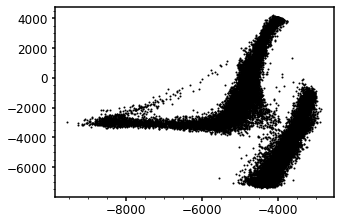

In [102]:
OC['Lx'] = OC['y']*OC['vz'] - OC['z']*OC['vy']
OC['Ly'] = OC['z']*OC['vx'] - OC['x']*OC['vz']
OC['Lz'] = OC['x']*OC['vy'] - OC['y']*OC['vz']




plt.scatter(OC['Lx'][OC['dhel']>20],OC['Lz'][OC['dhel']>20],color='black',s=1.)

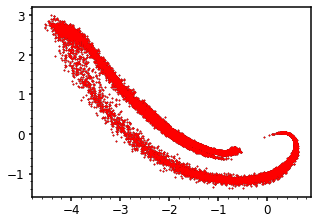

In [94]:
dLj,dBj,radj,vrj,dmulj,dmubj = gt.galactic(xtest,\
                                           ytest,\
                                           ztest,\
                                           vxtest,\
                                           vytest,\
                                           vztest,twopi=True)


#plt.scatter(ltest*180./np.pi,btest*180./np.pi,color='black',s=1.)


tmpdLj = dLj
tmpdLj[dLj>180]-=360.
#plt.scatter(tmpdLj,dBj,color='red',s=0.5)

plt.scatter(multest,mubtest,color='black',s=0.5)

plt.scatter(dmulj,dmubj,color='red',s=0.5)

10841
50000


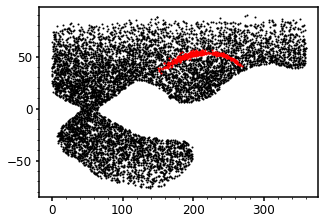

In [39]:

outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_oc_sgr_0_50k_all_heliocentric_noisefree.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_oc_sgr_0_50k_all_heliocentric_noisy.txt'




In = np.genfromtxt(outfile,skip_header=1)

x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

rapo = In[:,16]
gse  = In[:,17]
sdss = In[:,18]

r = np.sqrt(x*x+y*y+z*z)
print(len(np.where((sdss==1) & (d>20))[0]))

dlim = r>20
plt.scatter(l[(sdss==1) &(gse==0) & (dlim)],b[(sdss==1) &(gse==0) & (dlim)],color='black',s=1.)
plt.scatter(l[(sdss==1) &(gse==1) & (dlim)],b[(sdss==1) &(gse==1) & (dlim)],color='red',s=1.)
print(sdss.size)

#plt.scatter(d[(sd==1) &(gse==0) & (dlim)],dmb[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
#plt.scatter(d[(sd==1) &(gse==1) & (dlim)],dmb[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)



#plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)

In [40]:
newfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_oc_sgr_0_50k_all_heliocentric_noisefree_correct.txt'
newfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_oc_sgr_0_50k_all_heliocentric_noisy_correct.txt'


# distance-dependent error factors
pmprefac=  0.013
pmprefac=  0.008 # test a down-weighting of uncertainties

pmprefac=  0.004 # edr3?

dprefac = 0.2

f = open(newfile,'w')

print('x [kpc]; y [kpc]; z [kpc]; vx [km/s]; vy [km/s]; vz [km/s];      dL [deg]; dB [deg]; dist [kpc]; vlos [km/s]; dmul [marcsec/yr]; dmub [marcsec/yr];       edist[kpc]; evlos [km/s]; edmul [marcsec/yr]; edmub [marcsec/yr];       rapo [kpc]; gse; sdss?; [dead]; [dead]; [dead]; corr ',file=f)


for i in range(len(x)):

    # if not OC, copy the line exactly
    if gse[i] != 1:
        print(np.round(x[i],2),\
              np.round(y[i],2),\
              np.round(z[i],2),\
              np.round(vx[i],2),\
              np.round(vy[i],2),\
              np.round(vz[i],2),\
              np.round(l[i],2),\
              np.round(b[i],2),\
              np.round(d[i],2),\
              np.round( vr[i],2),\
              np.round( dml[i],4),\
              np.round( dmb[i],4),\
            np.round(ed[i],2),\
              np.round(evr[i],2),\
              np.round(edml[i],2),\
              np.round(edmb[i],2),\
            500.,\
              int(gse[i]),\
            int(sdss[i]),\
              0.0,0.0,0,0.0,\
              file=f)        
    else:
        
        xtest,ytest,ztest = x[i]-8.1,y[i],z[i]
        vxtest,vytest,vztest = vx[i]+11.1,vy[i]+245,vz[i]+7.3
        
        dLj,dBj,radj,vrj,dmulj,dmubj = gt.galactic(xtest,\
                                           ytest,\
                                           ztest,\
                                           vxtest,\
                                           vytest,\
                                           vztest,twopi=True)
        
        dLj,dBj,radj,vrj,dmulj,dmubj = gt.galactic(x[i],\
                                           y[i],\
                                           z[i],\
                                           vx[i],\
                                           vy[i],\
                                           vz[i],twopi=True)
        
        print(np.round(xtest,2),\
              np.round(ytest,2),\
              np.round(ztest,2),\
              np.round(vxtest,2),\
              np.round(vytest,2),\
              np.round(vztest,2),\
            np.round(dLj,2),\
              np.round(dBj,2),\
              np.round(radj,2),\
              np.round( vrj[0],2),\
              np.round( dmulj[0],4),\
              np.round( dmubj[0],4),\
            np.round(0.*0.05*radj,2),\
              np.round(0.*np.abs(dprefac*radj*np.random.normal()),2),\
              np.round(0.*np.abs(pmprefac*radj*np.random.normal()),4),\
              np.round(0.*np.abs(pmprefac*radj*np.random.normal()),4),\
            500.,\
              int(gse[i]),\
            int(sdss[i]),\
              0.0,0.0,0,0.0,\
              file=f)
    
f.close()





10934
50000


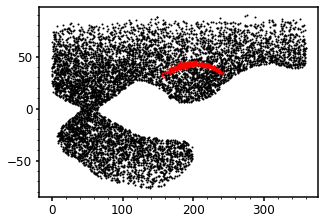

In [41]:

outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_oc_sgr_0_50k_all_heliocentric_noisefree_correct.txt'
outfile = '/Users/mpetersen/Dropbox/mike/Models_15May/mock_live_oc_sgr_0_50k_all_heliocentric_noisy_correct.txt'




In = np.genfromtxt(outfile,skip_header=1)

x    = In[:,0]
y    = In[:,1]
z    = In[:,2]
vx   = In[:,3]
vy   = In[:,4]
vz   = In[:,5]

l    = In[:,6]
b    = In[:,7]
d    = In[:,8]
vr   = In[:,9]
dml  = In[:,10]
dmb  = In[:,11]

ed   = In[:,12]
evr  = In[:,13]
edml = In[:,14]
edmb = In[:,15]

rapo = In[:,16]
gse  = In[:,17]
sdss = In[:,18]

r = np.sqrt(x*x+y*y+z*z)
print(len(np.where((sdss==1) & (d>20))[0]))

dlim = r>20
plt.scatter(l[(sdss==1) &(gse==0) & (dlim)],b[(sdss==1) &(gse==0) & (dlim)],color='black',s=1.)
plt.scatter(l[(sdss==1) &(gse==1) & (dlim)],b[(sdss==1) &(gse==1) & (dlim)],color='red',s=1.)
print(sdss.size)

#plt.scatter(d[(sd==1) &(gse==0) & (dlim)],dmb[(sd==1) &(gse==0) & (dlim)],color='black',s=1.)
#plt.scatter(d[(sd==1) &(gse==1) & (dlim)],dmb[(sd==1) &(gse==1) & (dlim)],color='red',s=1.)



#plt.scatter(l[(sd==1) & (d>50)],b[(sd==1) & (d>50)],color=cm.coolwarm((vr[(sd==1) & (d>50)]+200.)/400.),s=1.)#'black',s=1.)

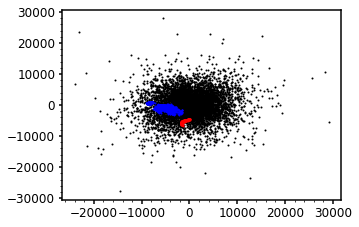

In [43]:
Lx = y*vz - z*vy
Ly = z*vx - x*vz
Lz = x*vy - y*vx

plt.scatter(Ly[(d>20) & (gse==0) & (sdss==1)],Lz[(d>20) & (gse==0) & (sdss==1)],color='black',s=1.)
plt.scatter(Ly[(d>20) & (gse==1) & (sdss==1)],Lz[(d>20) & (gse==1) & (sdss==1)],color='red',s=1.)
plt.scatter(Ly[(d>20) & (gse==2) & (sdss==1)],Lz[(d>20) & (gse==2) & (sdss==1)],color='blue',s=1.)